# 🩺💬 Doctor Scribbles - NorthAM Hackathon Submission

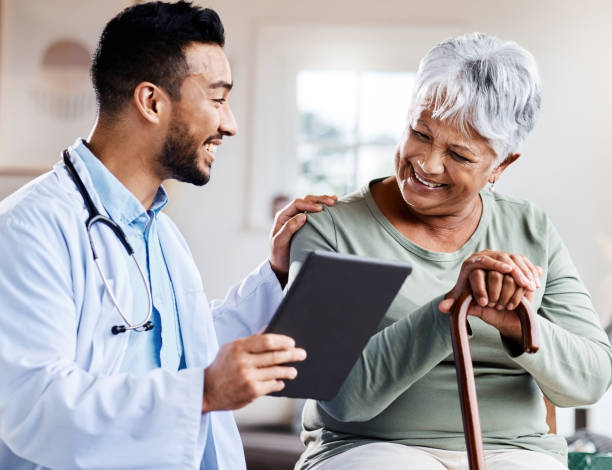

---

**Speech to Text 🗣️🔠 + Translation 🌎💬  + PaLM 🌴🦬**

---

| | |
|----------|-------------|
| Author(s)   | Ayo Adedeji (ayoad@) |
| Contributor(s) | Ayo Adedeji (ayoad@), Sarita Joshi (saritajoshi@)
| Last updated | 08/11/2023 |



## Overview

We seamlessly integrate Google Cloud's Speech-to-Text 🗣️🔠 and Translations APIs 🌎💬 to enable real-time transcription and translation of medical conversations between doctors and patients. Leveraging Google Cloud's PaLM API  🌴, our solution enhances transcriptions with __contextual speaker diarization__, ensuring accurate and nuanced transcripts that capture the essence of the conversation. Our solution also performs __advanced transcript correction__. It discerns subtle nuances, such as distinguishing between "cough" and "cup," based on prior context, ensuring the utmost accuracy and clarity in transcriptions.

Enter chat-bison 🦬, our intelligent, stateful chatbot. As conversations unfold, this AI-powered assistant dynamically tracks context and sentiment, generating __real-time recommendations__. From potential diagnoses and personalized treatment plans to task recommendations and actionable items, chat-bison empowers medical professionals and patients alike with insightful guidance.

This comprehensive system promises to revolutionize medical communication by offering informed insights and actionable suggestions, ultimately improving patient care and enhancing the decision-making process for healthcare providers

## Costs

This tutorial uses billable components of Google Cloud Platform (GCP):

- [Speech-to-Text API](https://cloud.google.com/speech-to-text)
- [Translation API](https://cloud.google.com/translate)
- [Vertex AI LLM APIs](https://cloud.google.com/vertex-ai/pricing#generative_ai_models)

## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DgrM1C8pKOV4OWiQA-mANGbyHxWngJ2P?usp=sharing) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
from google.colab import auth

auth.authenticate_user()

In [2]:
USER_EMAIL = "ayoad@google.com"  # @param {type:"string"}
PROJECT_ID = "aadev-2541"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}


## Enable APIs

Skip step if APIs are already enabled

If APIs are not already enabled, you will be prompted to login again but this time through the _!gcloud auth login_, so gcloud commands can be executed. This step __only__ has to be executed once (if requirements aren't already met) 😄

In [ ]:
!gcloud auth application-default login -q
!gcloud auth application-default set-quota-project {PROJECT_ID}
!gcloud config set project {PROJECT_ID}

# Enable Speech-to-Text API API
!gcloud services enable speech.googleapis.com --quiet

# Enable Translation API
!gcloud services enable translate.googleapis.com --quiet

# Enable Vertex AI
!gcloud services enable aiplatform.googleapis.com --quiet

## Install dependencies

In [ ]:
# Install Vertex AI
!pip install google-cloud-aiplatform==1.26.0 -q

# Install Speech-to-Text
!pip install google-cloud-speech==2.21.0 -q

# Install Translate
!pip install google-cloud-translate==3.12.0 -q

# Install PyAudio
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio==0.2.13 -q

# Install PyDub
!pip install pydub==0.25.1 -q

# Install Gradio
!pip install gradio==3.39.0 -q

---

#### ⚠️ Do not forget to click the "RESTART RUNTIME" button above.
1. Reinitialize your project variables that you specified in the Initialize environment section.

2. You can skip directly to the Import packages section afterwards.

---

## Import packages

In [7]:
import gradio as gr
import os
import pyaudio
import pydub
import time
import vertexai
import wave
from datetime import datetime
from google.cloud import speech, translate
from queue import Queue
from termcolor import cprint
from threading import Thread
from typing import List, Optional
from vertexai.language_models import TextGenerationModel
from vertexai.preview.language_models import ChatModel

vertexai.init(project=PROJECT_ID, location=REGION)

## Helper Functions / Classes

### MicrophoneStream

In [13]:
class MicrophoneStream:

    def __init__(
            self,
            project_id: str,
            region: str,
            channels: int = 1,
            frame_rate: int = 32000,
            audio_format: int = pyaudio.paInt16,
            chunk_size: int = 1024,
            target_record_seconds: int = 2,
            silence_threshold: int = -61,
            transcription_name: str = "",
            output_dir: Optional[str] = None,
            stop_phrase: str = "stop recording",
            temperature: float = 0.2,
            max_output_tokens: int = 1024,
            diarization_model: str = "text-bison@001",
            diarization_prompt: Optional[str] = None,
            chat_model: str = "chat-bison@001",
            chat_prompt: Optional[str] = None,
            alternative_language_codes: Optional[List[str]] = None,
            top_p: float = 0.8,
            top_k: int = 40,
            verbose: bool = True
    ):
        self.project_id = project_id
        self.region = region
        vertexai.init(project=project_id, location=region)

        self.channels = channels
        self.frame_rate = frame_rate
        self.audio_format = audio_format
        self.chunk_size = chunk_size
        self.target_record_seconds = target_record_seconds
        self.target_frame_count = (frame_rate * target_record_seconds) / chunk_size
        self.silence_threshold = silence_threshold # decibels
        self.transcription_name = transcription_name
        self.output_dir = output_dir if output_dir else os.getcwd()
        self.stop_phrase = stop_phrase
        self.temperature = temperature
        self.max_output_tokens = max_output_tokens
        self.diarization_model = diarization_model
        self.diarization_prompt = diarization_prompt
        self.chat_model = chat_model
        self.chat_prompt = chat_prompt
        self.alternative_language_codes = alternative_language_codes
        self.chat = None
        self.top_p = top_p
        self.top_k = top_k
        self.verbose = verbose
        self.start_time = None
        self.start_datetime = None
        self.messages = Queue()
        self.recordings = Queue()
        self.raw_transcription_inputs = Queue()
        self.enhanced_transcription_inputs = Queue()
        self.outputs = []
        self.chat_outputs = []
        self.temp_outputs = []
        self.speech_client = speech.SpeechClient()

        # gradio specific parameters
        self.gradio_is_running = False
        self.gradio_running_audio_segment = pydub.AudioSegment.empty()
        self.gradio_active_chat = []
        self.gradio_corrected_chat = []
        self.gradio_latest_recommendations = ""

    def start_recording(self):
        """Start recording"""
        # start record microphone thread
        self.messages.put(True)
        record = Thread(target=self.record_microphone)
        record.start()
        self.start_time = time.time()
        self.start_datetime = datetime.fromtimestamp(self.start_time)

        # start speech recognition thread
        transcribe = Thread(target=self.speech_recognition)
        transcribe.start()

        # start enhanced transcription thread
        enhance_transcription = Thread(target=self.get_llm_doctor_patient_speech_diarization)
        enhance_transcription.start()

        # start latest recommendations thread
        latest_recommendations = Thread(target=self.get_latest_recommendations)
        latest_recommendations.start()

    def stop_recording(self):
        """Stop recording"""
        self.messages.get()

        if self.verbose is True:
            print("Recording stopped.")
            self.write_transcription_output()

    def write_transcription_output(self):
        """Write transcription output"""

        output_str = ("-" * 80).join(self.outputs)
        chat_output_str = ("-" * 80).join(self.chat_outputs)
        output_lines = output_str.split("\n")
        chat_output_lines = chat_output_str.split("\n")

        # open the file in write mode
        output_file_name = os.path.join(
            self.output_dir,
            self.transcription_name.split(".")[0] + "-" +
            datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".txt")
        with open(os.path.join(self.output_dir, output_file_name), 'w') as output_file:
            # write each string from the list to the file
            for output_line, chat_output_line in zip(output_lines, chat_output_lines):
                # line = line.lstrip()
                output_file.write(output_line + "\n")
                output_file.write(chat_output_line + "\n")

    def record_microphone(self):
        """Record microphone"""

        p = pyaudio.PyAudio()

        stream = p.open(format=self.audio_format,
                        channels=self.channels,
                        rate=self.frame_rate,
                        input=True,
                        frames_per_buffer=self.chunk_size)

        sample_width = p.get_sample_size(pyaudio.paInt16)
        frames = []

        while not self.messages.empty():
            data = stream.read(self.chunk_size)

            audio_segment = pydub.AudioSegment(
                data=data,
                sample_width=sample_width,
                channels=self.channels,
                frame_rate=self.frame_rate
            )

            frames.append(data)

            if len(frames) >= self.target_frame_count and audio_segment.dBFS < self.silence_threshold:
                self.recordings.put(frames.copy())
                frames = []

        stream.stop_stream()
        stream.close()
        p.terminate()

    def get_llm_doctor_patient_speech_diarization(self):
        """Get LLM Doctor Patient Speech Diarization"""

        while not self.messages.empty():
            temp_outputs = self.raw_transcription_inputs.get()

            parameters = {
                "temperature": self.temperature,
                "max_output_tokens": self.max_output_tokens,
                "top_p": self.top_p,
                "top_k": self.top_k
            }
            model = TextGenerationModel.from_pretrained(self.diarization_model)
            prompt = self.diarization_prompt

            if len(self.outputs) > 0:
                input_text = ("-" * 80).join(temp_outputs)
            else:
                input_text = ("-" * 80).join(temp_outputs + self.outputs[-1:])

            import re
            pattern = r"Time: (\d{1,2}:\d{2}:\d{2}) / (\d{4}-\d{2}-\d{2} \d{2}:\d{2} [APap][Mm])"

            matches = re.findall(pattern, input_text)

            for match in matches:
                print("Time:", match[0])
                print("Timestamp:", match[1])
                print()

            prompt = prompt.format(input_text=input_text, timestamp_hint=list(matches))
            response = model.predict(prompt, **parameters)

            enhanced_transcription = response.text.split("output:")[-1]

            self.outputs.append(enhanced_transcription)
            cprint(response.text, "blue", attrs=["bold"])

            if self.gradio_is_running:
              for corrected_message in enhanced_transcription.split("Time:"):
                self.gradio_corrected_chat.append(("Time:" + corrected_message, "---"))

            if not self.chat:
                self.create_chat()

            self.enhanced_transcription_inputs.put(enhanced_transcription)

    def create_chat(self):
        """Create chat"""
        vertexai.init(project=self.project_id, location=self.region)
        chat_model = ChatModel.from_pretrained(self.chat_model)

        context = self.chat_prompt

        chat = chat_model.start_chat(
            context=context,
            temperature=self.temperature,
            max_output_tokens=self.max_output_tokens,
            top_p=self.top_p,
            top_k=self.top_k,
        )
        self.chat = chat

    def get_latest_recommendations(self):
        """Get latest recommendations"""

        while not self.messages.empty():
            enhanced_transcription = self.enhanced_transcription_inputs.get()

            chat_output = self.chat.send_message(enhanced_transcription)

            if chat_output and chat_output != "" and chat_output != '""':
                cprint(chat_output, "red", attrs=["bold"])

                if self.gradio_is_running:
                  self.gradio_latest_recommendations = chat_output

            self.chat_outputs.append(chat_output.text)

    def print_response(self, response: speech.RecognizeResponse, current_time):
        """Print response"""
        if len(response.results) > 0:
            self.print_result(response.results[-1], current_time)

    def print_result(self, result: speech.SpeechRecognitionResult, current_time):
        """Print result"""
        current_datetime = datetime.fromtimestamp(current_time)
        duration = current_datetime - self.start_datetime

        best_alternative = result.alternatives[0]
        cprint("-" * 80, "white")
        cprint("Time: {} / {}".format(str(duration).split('.')[0], current_datetime.strftime('%Y-%m-%d %I:%M %p %Z')), "white")
        cprint(f"language_code: {result.language_code}", "white")
        cprint(f"transcript:    {best_alternative.transcript}", "white")
        cprint(f"confidence:    {best_alternative.confidence:.0%}", "white")


        if self.stop_phrase in best_alternative.transcript.lower():
            self.stop_recording()

        if result.language_code != "en-us":
            client = translate.TranslationServiceClient()

            response = client.translate_text(
                parent=f"projects/{self.project_id}",
                contents=[best_alternative.transcript],
                target_language_code="en",
            )
            translation = response.translations[0]
            print(f"{result.language_code} → en : {translation.translated_text}")
            if self.gradio_is_running:
              gradio_output = f"""\
              Time: {str(duration).split('.')[0]} / {current_datetime.strftime('%Y-%m-%d %I:%M %p %Z')}
              language_code: {result.language_code}
              {best_alternative.transcript}
              {result.language_code} → en : {translation.translated_text}
              """
            self.temp_outputs.append(translation.translated_text)
            self.gradio_active_chat.append((gradio_output, f"confidence:    {best_alternative.confidence:.0%}",))
        else:
            if self.gradio_is_running:
              gradio_output = f"""\
              Time: {str(duration).split('.')[0]} / {current_datetime.strftime('%Y-%m-%d %I:%M %p %Z')}
              language_code: {result.language_code}
              {best_alternative.transcript}
              """
            self.gradio_active_chat.append((gradio_output, f"confidence:    {best_alternative.confidence:.0%}",))

            self.temp_outputs.append(best_alternative.transcript)


        if len(self.temp_outputs) > 2:
            self.raw_transcription_inputs.put(self.temp_outputs)
            self.temp_outputs = []

    def speech_recognition(self):
        """Speech recognition"""

        if self.transcription_name:
            cprint(f'Stream for {self.transcription_name}', "yellow")

        cprint('Listening, say "Stop Recording" to stop.', "yellow")
        cprint("=====================================================", "yellow")

        while not self.messages.empty():
            current_time = time.time()
            frames = self.recordings.get()

            audio = speech.RecognitionAudio(content=b''.join(frames))
            config = speech.RecognitionConfig(
                encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
                enable_automatic_punctuation=True,
                model="latest_short",
                sample_rate_hertz=self.frame_rate,
                language_code="en-US",
                alternative_language_codes=self.alternative_language_codes,
                max_alternatives=1,
            )

            response = self.speech_client.recognize(request={"config": config, "audio": audio})
            self.print_response(response, current_time)

    def gradio_callback(self, audio):
        """Gradio Callback"""

        current_time = time.time()

        with wave.open(audio, "rb") as wave_file:
            FRAME_RATE = wave_file.getframerate()

        audio_segment = pydub.AudioSegment.from_file(file = audio, format = "wav")
        self.gradio_running_audio_segment += audio_segment

        if audio_segment.dBFS > self.silence_threshold:
          return self.gradio_active_chat
        else:
          pass

        speech_audio = speech.RecognitionAudio(content=self.gradio_running_audio_segment.raw_data)
        self.gradio_running_audio_segment = pydub.AudioSegment.empty()

        config = speech.RecognitionConfig(
            encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
            enable_automatic_punctuation=True,
            model="latest_short",
            sample_rate_hertz=FRAME_RATE,
            language_code="en-US",
            alternative_language_codes=self.alternative_language_codes,
            max_alternatives=1,
        )

        response = self.speech_client.recognize(request={"config": config, "audio": speech_audio})
        self.print_response(response, current_time)
        return self.gradio_active_chat

    def run_gradio(self):
      """Run Gradio"""

      self.gradio_is_running = True
      self.start_time = time.time()
      self.start_datetime = datetime.fromtimestamp(self.start_time)

      # start enhance transcription thread
      self.messages.put(True)
      enhance_transcription = Thread(target=self.get_llm_doctor_patient_speech_diarization)
      enhance_transcription.start()

      # start latest recommendations thread
      latest_recommendations = Thread(target=self.get_latest_recommendations)
      latest_recommendations.start()

      def update_gradio_outputs():
        return self.gradio_corrected_chat, self.gradio_latest_recommendations

      with gr.Blocks() as demo:
        gr.Markdown(
        """
        ## Doctor Scribbles Demo

       <img src="https://storage.googleapis.com/aadev-2541-public-assets/doctor-scribbles-img-1.png" alt="drawing" style="width:200px;"/>

        """)

        with gr.Row():
          microphone = gr.Audio(source="microphone", type="filepath", streaming=True)

        with gr.Row():
          with gr.Column(scale=1):
            speech_to_text_output = gr.Chatbot(elem_id="chatbot-1", label="Speech-to-Text Output").style(height=500)

          with gr.Column(scale=1):
            llm_enhanced_transcription_output = gr.Chatbot(elem_id="chatbot-2", label="LLM Enhanced Transcription").style(height=500)


        with gr.Row():
          latest_recommendations = gr.Textbox(label="Recommendations")

        microphone.stream(
            self.gradio_callback,
            inputs=[microphone],
            outputs=[speech_to_text_output]
        )

        microphone.stop_recording(self.stop_recording)

        demo.load(update_gradio_outputs,
                  inputs=None,
                  outputs=[llm_enhanced_transcription_output, latest_recommendations],
                  every=0.5)

      demo.queue()
      demo.launch(share=True, debug=False)

## Prompts

### Diarization Prompt

In [9]:
diarization_prompt = """\
You are a helpful medical knowledge assistant. Your goal is to process raw transcripts of medical conversations and transform them into corrected transcripts with speaker diarization between a Doctor and a Patient and phrasing improvements. Your task involves accurately identifying and labeling speakers, ensuring proper punctuation, capitalization, grammar, and syntax, as well as enhancing phrasing and clarity. Additionally, you should leverage contextual understanding to resolve ambiguities and accurately convey the intended meaning. Throughout the conversation, you should maintain consistency in vocabulary and terminology, eliminate repetitions and redundancies, and make factual corrections when necessary. By applying these rules and your medical knowledge, you will provide an optimized transcript that enhances readability and effectively captures the dialogue\'s content and context. Output the predicted speaker under the \"LLM predicted speaker\" label, output your phrasing improving of the transcript under the \"LLM corrected transcript\" label, and output your confidence for the quality of phrasing improvement under the \"LLM confidence\" label.

input: Time: 0:00:03 / 2023-06-29 08:50 PM
language_code: en-us
transcript:    Good afternoon. How can I assist you today?
confidence:    97%
--------------------------------------------------------------------------------
Time: 0:00:07 / 2023-06-29 08:50 PM
language_code: en-us
transcript:    Hi doctor. I\'ve been experiencing a persistent cough for the past week, and it\'s not getting any better.
confidence:    95%
output: Time: 0:00:03 / 2023-06-29 08:50 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  Good afternoon. How can I assist you today?
LLM corrected transcript:    Good afternoon. How can I assist you today?
confidences:                 97%
LLM confidence:              97%
--------------------------------------------------------------------------------
Time: 0:00:07 / 2023-06-29 08:50 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  Hi doctor. I\'ve been experiencing a persistent cough for the past week, and it\'s not getting any better.
LLM corrected transcript:    Hi doctor. I\'ve been experiencing a persistent cough for the past week, and it\'s not getting any better.
confidences:                 95%
LLM confidence:              100%

input: Time: 0:00:15 / 2023-06-29 08:50 PM
language_code: en-us
transcript:    Hmm. I see have you noticed any other symptoms accompanying the call any fever chest pain?
confidence:    96%
--------------------------------------------------------------------------------
Time: 0:00:21 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    or shortness of breath
confidence:    96%
output: Time: 0:00:15-0:00:21 / 2023-06-29 08:50 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  Hmm. I see have you noticed any other symptoms accompanying the call any fever chest pain? or shortness of breath
LLM corrected transcript:    Hmm. I see have you noticed any other symptoms accompanying the cough? Any fever, chest pain, or shortness of breath?
confidences:                 96%,96%
LLM confidence:              98%

input: Time: 0:00:22 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    You know, I haven\'t had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur.
confidence:    96%
--------------------------------------------------------------------------------
Time: 0:00:35 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    especially during physical activities
confidence:    94%
output: Time: 0:00:22-0:00:35 / 2023-06-29 08:51 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  You know, I haven\'t had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur. especially during physical activities
LLM corrected transcript:    You know, I haven\'t had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur. Especially during physical activities.
confidences:                 96%,94%
LLM confidence:              98%

input: Time: 0:00:36 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    I understand.
confidence:    97%
--------------------------------------------------------------------------------
Time: 0:00:38 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    Have you been in contact with anyone who has been sick recently?
confidence:    97%
output: Time: 0:00:36-0:00:38 / 2023-06-29 08:51 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I understand. Have you been in contact with anyone who has been sick recently?
LLM corrected transcript:    I understand. Have you been in contact with anyone who has been sick recently?
confidences:                 97%,97%
LLM confidence:              98%

input: Time: 0:00:36-0:00:38 / 2023-06-29 08:51 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I understand. Have you been in contact with anyone who has been sick recently?
LLM corrected transcript:    I understand. Have you been in contact with anyone who has been sick recently?
confidences:                 97%,97%
LLM confidence:              98%
--------------------------------------------------------------------------------
Time: 0:00:41 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    It could help determine if this could be related to an infection.
confidence:    96%
output: Time: 0:00:36-0:00:41 / 2023-06-29 08:51 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I understand. Have you been in contact with anyone who has been sick recently?  It could help determine if this could be related to an infection.
LLM corrected transcript:    I understand. Have you been in contact with anyone who has been sick recently?  It could help determine if this could be related to an infection.
confidences:                 97%,97%,96%
LLM confidence:              98%

input: Time: 0:00:36-0:00:41 / 2023-06-29 08:51 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I understand. Have you been in contact with anyone who has been sick recently?  It could help determine if this could be related to an infection.
LLM corrected transcript:    I understand. Have you been in contact with anyone who has been sick recently?  It could help determine if this could be related to an infection.
confidences:                 97%,97%,96%
LLM confidence:              98%
--------------------------------------------------------------------------------
Time: 0:00:44 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    Well, my colleague at work had a bad cold a couple of weeks ago.
confidence:    94%
output: Time: 0:00:36-0:00:44 / 2023-06-29 08:51 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I understand. Have you been in contact with anyone who has been sick recently? It could help determine if this could be related to an infection.
LLM corrected transcript:    I understand. Have you been in contact with anyone who has been sick recently? It could help determine if this could be related to an infection.
confidences:                 97%,97%,96%
LLM confidence:              98%
--------------------------------------------------------------------------------
Time: 0:00:44 / 2023-06-29 08:51 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  Well, my colleague at work had a bad cold a couple of weeks ago.
LLM corrected transcript:    Well, my colleague at work had a bad cold a couple of weeks ago.
confidences:                 94%
LLM confidence:              94%

input: Time: 0:02:18 / 2023-06-29 08:55 PM
language_code: en-us
transcript: based on your symptoms it seems like you might be experiencing a respiratory inclement
confidence: 97%
--------------------------------------------------------------------------------
Time: 0:02:24 / 2023-06-29 08:55 PM
language_code: en-us
transcript: oh no is it serious
confidence: 96%
--------------------------------------------------------------------------------
Time: 0:02:30 / 2023-06-29 08:55 PM
language_code: en-us
transcript: It\'s not uncommon to have respiratory infections, and most cases can be treated with rest, flutes, and over-the-counter medication.
confidence: 95%
--------------------------------------------------------------------------------
Time: 0:02:35 / 2023-06-29 08:55 PM
language_code: en-us
transcript: that\'s a relief what can I do to alleviate the cinnamons
confidence: 97%
output: Time: 0:02:18 / 2023-06-29 08:55 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  based on your symptoms it seems like you might be experiencing a respiratory inclement
LLM corrected transcript:    Based on your symptoms, it seems like you might be experiencing a respiratory infection.
confidences:                 97%
LLM confidence:              98%
--------------------------------------------------------------------------------
Time: 0:02:24 / 2023-06-29 08:55 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  oh no is it serious
LLM corrected transcript:    Oh no, is it serious?
confidences:                 96%
LLM confidence:              99%
--------------------------------------------------------------------------------
Time: 0:02:30 / 2023-06-29 08:55 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  It\'s not uncommon to have respiratory infections, and most cases can be treated with rest, flutes, and over-the-counter medication.
LLM corrected transcript:    It\'s not uncommon to have respiratory infections, and most cases can be treated with rest, fluids, and over-the-counter medication.
confidences:                 95%
LLM confidence:              96%
--------------------------------------------------------------------------------
Time: 0:02:35 / 2023-06-29 08:55 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  that\'s a relief what can I do to alleviate the cinnamons
LLM corrected transcript:    That\'s a relief. What can I do to alleviate the symptoms?
confidences:                 97%
LLM confidence:              100%

input: Time: 0:00:22 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    You know, I haven\'t had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur.
confidence:    96%
--------------------------------------------------------------------------------
Time: 0:00:35 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    especially during physical activities
confidence:    94%
--------------------------------------------------------------------------------
Time: 0:00:36 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    I understand.
confidence:    97%
--------------------------------------------------------------------------------
Time: 0:00:38 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    Have you been in contact with anyone who has been sick recently?
confidence:    97%
--------------------------------------------------------------------------------
Time: 0:00:41 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    It could help determine if this could be related to an infection.
confidence:    96%
output: Time: 0:00:22-0:00:35 / 2023-06-29 08:51 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  You know, I haven\'t had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur. especially during physical activities
LLM corrected transcript:    You know, I haven\'t had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur. Especially during physical activities.
confidences:                 96%,94%
LLM confidence:              98%
--------------------------------------------------------------------------------
Time: 0:00:36-0:00:41 / 2023-06-29 08:51 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I understand. Have you been in contact with anyone who has been sick recently? It could help determine if this could be related to an infection.
LLM corrected transcript:    I understand. Have you been in contact with anyone who has been sick recently? It could help determine if this could be related to an infection.
confidences:                 97%,97%,96%
LLM confidence:              98%


input: Time: 0:02:24 / 2023-06-29 08:55 PM
language_code: en-us
transcript: I guess so.
confidence: 96%
--------------------------------------------------------------------------------
Time: 0:02:25 / 2023-06-29 08:55 PM
language_code: en-us
transcript: i\'ve been coughing a lot lately, especially at night it\'s been quite bothersome and I\'ve been feeling tired because of it i also noticed a slight fever yesterday
confidence: 94%
output: Time: 0:02:24-0:02:25 / 2023-06-29 08:55 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  I guess so. I\'ve been coughing a lot lately, especially at night. It\'s been quite bothersome and I\'ve been feeling tired because of it. i\'ve been coughing a lot lately, especially at night it\'s been quite bothersome and I\'ve been feeling tired because of it i also noticed a slight fever yesterday
LLM corrected transcript:    I guess so. I\'ve been coughing a lot lately, especially at night. It\'s been quite bothersome and I\'ve been feeling tired because of it. I also noticed a slight fever yesterday.
confidences:                 96%,94%
LLM confidence:              98%


input: Time: 0:14:18 / 2023-06-29 08:55 PM
language_code: en-us
transcript: I see. Persistent nighttime coughing and fatigue can be concerning. It\'s good that you\'ve noticed the fever as well. These symptoms could be indicative of an underlying respiratory infection. i recommend conducting a borrough examination to determine the cause and provide appropriate treatment.
confidence: 96%
--------------------------------------------------------------------------------
Time: 0:14:23 / 2023-06-29 08:55 PM
language_code: en-us
transcript: We\'ll need to run some tests to get a better understanding of your condition. I\'ll order a complete blood count and a chest X-ray to start. We may need to consider additional tests based on the results. Is that okay with you?
confidence: 98%
output: Time: 0:14:18-0:14:23 / 2023-06-29 08:55 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I see. Persistent nighttime coughing and fatigue can be concerning. It\'s good that you\'ve noticed the fever as well. These symptoms could be indicative of an underlying respiratory infection. I recommend conducting a borrough examination to determine the cause and provide appropriate treatment.
LLM corrected transcript:    I see. Persistent nighttime coughing and fatigue can be concerning. It\'s good that you\'ve noticed the fever as well. These symptoms could be indicative of an underlying respiratory infection. I recommend conducting a thorough examination to determine the cause and provide appropriate treatment. We\'ll need to run some tests to get a better understanding of your condition. I\'ll order a complete blood count and a chest X-ray to start. We may need to consider additional tests based on the results. Is that okay with you?
confidences:                 96%,98%
LLM confidence:              98%


input: Time: 1:03:15 / 2023-06-29 08:55 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I understand your concerns. Have you undergone any genetic testing, such as non-invasive prenatal testing (NIPT)?
confidences:                 96%,98%
LLM confidence:              98%
--------------------------------------------------------------------------------
Time: 1:09:23 / 2023-08-31 08:55 PM
language_code: en-us
transcript: It could provide valuable information about your risk. We can discuss the benefits and options in detail.
confidence: 96%
output: Time: 1:03:15-1:09:23 / 2023-06-29 08:55 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  I understand your concerns. Have you undergone any genetic testing, such as non-invasive prenatal testing (NIPT)? It could provide valuable information about your risk. We can discuss the benefits and options in detail.
LLM corrected transcript:    I understand your concerns. Have you undergone any genetic testing, such as non-invasive prenatal testing (NIPT)? It could provide valuable information about your risk. We can discuss the benefits and options in detail.
confidences:                 96%,98%,96%
LLM confidence:              98%


input: Time: 0:00:15 / 2023-06-29 08:50 PM
language_code: en-us
transcript:    Hmm. I see have you noticed any other symptoms accompanying the call any fever chest pain?
confidence:    96%
--------------------------------------------------------------------------------
Time: 0:00:21 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    or shortness of breath
confidence:    96%
--------------------------------------------------------------------------------
Time: 0:00:22 / 2023-06-29 08:51 PM
language_code: en-us
transcript:    you know I havent had a fever or chest pain but I do feel a bit short of breath when the coughing fits occur.
confidence:    96%
output: Time: 0:00:15-0:00:21 / 2023-06-29 08:50 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  Hmm. I see have you noticed any other symptoms accompanying the call any fever chest pain? or shortness of breath
LLM corrected transcript:    Hmm. I see have you noticed any other symptoms accompanying the cough? Any fever, chest pain, or shortness of breath?
confidences:                 96%,96%
LLM confidence:              98%
--------------------------------------------------------------------------------
Time: 0:00:22 / 2023-06-29 08:51 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  you know I havent had a fever or chest pain but I do feel a bit short of breath when the coughing fits occur.
LLM corrected transcript:    You know, I haven\'t had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur.
confidences:                 96%
LLM confidence:              96%

input:
{input_text}

output:
"""

### Chat Prompt

In [10]:
chat_prompt = """\
As a stateful and helpful medical assistant, your role is to provide comprehensive diagnostic and treatment recommendations based on the ongoing conversation between the doctor and the patient. Your goal is to track the conversation in real-time, monitor applicable diagnoses, treatment plans, and recommended/explicit tasks specific to the doctor and patient, and provide accurate and helpful recommendations tailored to the patient's condition and the doctor's expertise.

Throughout the conversation, you should output the names or descriptions of new diagnoses, treatment plans, recommended tasks, or explicit tasks that gain relevancy. Append "(+)" at the end of the name or description to indicate their gain relevance following a new chat entry. If a diagnosis, treatment plan, recommended task, or explicit task is addressed during the conversation following a new chat entry, output the corresponding name or description with a check mark at the end. Conversely, if a diagnosis, treatment plan, recommended task, or explicit task on your running list loses relevancy (e.g. diagnoses or treatment plan no longer valid), output the corresponding name or description with a negative sign (-) at the end following a new chat entry.

If the transcript segment(s) of a new chat entry add no new information or does not make a difference to the state of your stateful running list of diagnoses, treatment plans, recommended tasks, or explicit tasks, simply ignore the transcript segment(s) and output an empty string.

If nothing medically relevant has been said yet in context of your role when tracking the conversation, always output an empty string until something medically relevant has been said and then begin task as has been described.

Below are example inputs and outputs of a stateful running list progression through an example chat.

Do not explicitly copy these example responses. Only use them as a guide to help you diligently learn what is means to capture a running stateful list over time.

Input 1:
Time: 0:00:03 / 2023-06-29 08:50 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  Good afternoon. How can I assist you today?
LLM corrected transcript:    Good afternoon. How can I assist you today?
confidences:                 97%
LLM confidence:              97%
--------------------------------------------------------------------------------
Time: 0:00:07 / 2023-06-29 08:50 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  Hi doctor. I've been experiencing a persistent cough for the past week, and it's not getting any better.
LLM corrected transcript:    Hi doctor. I've been experiencing a persistent cough for the past week, and it's not getting any better.
confidences:                 95%
LLM confidence:              100%

Output 1:
Potential Diagnoses:
- Acute bronchitis: The persistent cough could be a symptom of acute bronchitis, which is an inflammation of the bronchial tubes. (+)
- Allergic rhinitis: The cough could be related to allergic rhinitis, as it can cause postnasal drip and throat irritation, leading to a cough. (+)
- Upper respiratory infection: A persistent cough can also be a result of an upper respiratory infection, such as a common cold. (+)

Treatment Plans:
- Symptomatic relief: Recommend over-the-counter cough suppressants and throat lozenges to alleviate the cough and soothe the throat. (+)
- Steam inhalation: Suggest the patient try steam inhalation to help relieve any congestion and soothe the airways. (+)
- Allergy management: If allergic rhinitis is suspected, advise the patient to avoid triggers, use nasal saline rinses, and consider antihistamines or nasal corticosteroids. (+)
- Rest and hydration: Encourage the patient to get adequate rest and stay hydrated to support the body's healing process. (+)

Recommended Tasks:
- Doctor: Assess the severity of the cough and ask follow-up questions to gather more information about associated symptoms, such as fever, chest pain, or shortness of breath. (+)
- Doctor: Perform a physical examination, including listening to the patient's lungs, to assess any abnormal sounds or signs of infection. (+)
- Doctor: Consider ordering diagnostic tests, such as a chest X-ray or sputum culture, if necessary, to rule out other underlying conditions. (+)

Input 2:
Time: 0:00:15-0:00:22 / 2023-06-29 08:50 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  Hmm. I see have you noticed any other symptoms accompanying the call any fever chest pain? or shortness of breath
LLM corrected transcript:    Hmm. I see have you noticed any other symptoms accompanying the cough? Any fever, chest pain, or shortness of breath?
confidences:                 96%,96%
LLM confidence:              98%
--------------------------------------------------------------------------------
Time: 0:00:22-0:00:36 / 2023-06-29 08:51 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  You know, I haven't had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur. especially during physical activities
LLM corrected transcript:    You know, I haven't had a fever or chest pain, but I do feel a bit short of breath when the coughing fits occur. Especially during physical activities.
confidences:                 96%,94%
LLM confidence:
             98%
Output 2:
Potential Diagnoses:
- Gastroesophageal reflux disease (GERD) (+)

Recommended Tasks:
- Doctor: Assess the severity of the cough and ask follow-up questions to gather more information about associated symptoms, such as fever, chest pain, or shortness of breath. (✓)

Input 3:
Time: 0:01:02 / 2023-06-29 08:51 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  Yes doctor. I trust your judgments.
LLM corrected transcript:    Yes doctor. I trust your judgments.
confidences:                 96%
LLM confidence:              96%

Output 3:
""

Input 4:
Time: 0:01:13-0:01:30 / 2023-06-29 08:51 PM
LLM predicted speaker:       Doctor
language_code:               en-us
transcript:                  Excellent. I'll arrange your chest x-ray for you as soon as possible. In the meantime, I recommend getting plenty of rest. Staying hydrated and avoiding any irritants such as smoke or strong sense. If your symptoms worsen or you develop a fever. Please don't hesitate to contact me. immediately
LLM corrected transcript:    Excellent. I'll arrange your chest x-ray for you as soon as possible. In the meantime, I recommend getting plenty of rest, staying hydrated, and avoiding any irritants such as smoke or strong scents. If your symptoms worsen or you develop a fever, please don't hesitate to contact me. Immediately.
confidences:                 96%,97%,96%,94%,97%,97%
LLM confidence:              95%
--------------------------------------------------------------------------------
Time: 0:01:30-0:01:38 / 2023-06-29 08:52 PM
LLM predicted speaker:       Patient
language_code:               en-us
transcript:                  Thank you doctor. I appreciate your prompt attention to this matter. Of all your advice and keep an eye on any changes in my condition.
LLM corrected transcript:    Thank you doctor. I appreciate your prompt attention to this matter. I will follow your advice and keep an eye on any changes in my condition.
confidences:                 96%,90%
LLM confidence:              90%

Output 4:
Recommended Tasks:
- Doctor: Consider ordering diagnostic tests, such as a chest X-ray or sputum culture, if necessary, to rule out other underlying conditions. (✓)

Explicit Tasks:
- Patient: Stay hydrated and avoid any irritants such as smoke or strong scents. If symptoms worsen or you develop a fever. Contact doctor. (+)
- Doctor: Arrange a chest X-ray for the patient as soon as possible. (+)

Input:
"""

## Start Recording

Full list of [supported languages](https://cloud.google.com/speech-to-text/docs/speech-to-text-supported-languages)

In [ ]:
microphone_stream = MicrophoneStream(
    project_id="aadev-2541",
    region="us-central1",
    diarization_prompt=diarization_prompt,
    chat_prompt=chat_prompt,
    alternative_language_codes=["hi-IN", "es-US"],
    silence_threshold=-50,
    transcription_name="transcription-1b-llm-corrected-output-testing.txt",
)

microphone_stream.run_gradio()